<a href="https://colab.research.google.com/github/claudio1975/Generative_Modelling/blob/main/Synthetic_Data_with_CGMM_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prepare Workspace

In [ ]:
! pip install shap &> /dev/null

In [ ]:
import os #  for environment operations
import random # for generating random numbers
import numpy as np # for numerical operations
import pandas as pd # for data manipulation
import tensorflow as tf # for building deep learning models
from tensorflow import keras
from keras import layers, Model
from tensorflow.keras.layers import Concatenate
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns
from matplotlib.pyplot import subplots
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance
from scipy.stats import ks_2samp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import umap
from sklearn.linear_model import TweedieRegressor
import shap
from sklearn.mixture import GaussianMixture

In [ ]:
DEFAULT_RANDOM_SEED = 0 # Set a random seed for reproducibility throughout Python, NumPy, and TensorFlow operations
random.seed(DEFAULT_RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(DEFAULT_RANDOM_SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(DEFAULT_RANDOM_SEED)
tf.random.set_seed(DEFAULT_RANDOM_SEED)

### Upload dataset and data handling

In [ ]:
df=pd.read_csv('/content/ausprivauto0405.csv')

In [ ]:
print(df.shape)

(67856, 9)


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67856 entries, 0 to 67855
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Exposure     67856 non-null  float64
 1   VehValue     67856 non-null  float64
 2   VehAge       67856 non-null  object 
 3   VehBody      67856 non-null  object 
 4   Gender       67856 non-null  object 
 5   DrivAge      67856 non-null  object 
 6   ClaimOcc     67856 non-null  int64  
 7   ClaimNb      67856 non-null  int64  
 8   ClaimAmount  67856 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 4.7+ MB
None


In [ ]:
print(df.columns)

Index(['Exposure', 'VehValue', 'VehAge', 'VehBody', 'Gender', 'DrivAge',
       'ClaimOcc', 'ClaimNb', 'ClaimAmount'],
      dtype='object')


In [ ]:
df.head()

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
0,0.303901,1.06,old cars,Hatchback,Female,young people,0,0,0.0
1,0.648871,1.03,young cars,Hatchback,Female,older work. people,0,0,0.0
2,0.569473,3.26,young cars,Utility,Female,young people,0,0,0.0
3,0.317591,4.14,young cars,Station wagon,Female,young people,0,0,0.0
4,0.648871,0.72,oldest cars,Hatchback,Female,young people,0,0,0.0


In [ ]:
df_duplicated_rows=df[df.duplicated()]
df_duplicated_rows

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
63,0.095825,2.650,youngest cars,Sedan,Female,working people,0,0,0.0
152,0.616016,0.450,oldest cars,Hatchback,Female,oldest people,0,0,0.0
1003,0.002738,3.170,youngest cars,Utility,Male,youngest people,0,0,0.0
1031,0.848734,4.700,youngest cars,Station wagon,Female,young people,0,0,0.0
1165,0.903491,1.280,oldest cars,Station wagon,Male,oldest people,0,0,0.0
...,...,...,...,...,...,...,...,...,...
67769,0.251882,0.980,old cars,Sedan,Female,old people,0,0,0.0
67779,0.851472,5.236,youngest cars,Station wagon,Female,older work. people,0,0,0.0
67796,0.908966,2.440,youngest cars,Sedan,Female,old people,0,0,0.0
67811,0.769336,1.200,old cars,Sedan,Male,youngest people,0,0,0.0


In [ ]:
df=df.drop_duplicates()

In [ ]:
df_duplicated_col=df.columns[df.columns.duplicated()]
df_duplicated_col

Index([], dtype='object')

In [ ]:
missing=df.isnull().sum()/df.shape[0]*100
missing

,0
Exposure,0.0
VehValue,0.0
VehAge,0.0
VehBody,0.0
Gender,0.0
DrivAge,0.0
ClaimOcc,0.0
ClaimNb,0.0
ClaimAmount,0.0


### Encoding

In [ ]:
print(df['VehAge'].unique())
print(df['DrivAge'].unique())
print(df['VehBody'].unique())
print(df['Gender'].unique())


['old cars' 'young cars' 'oldest cars' 'youngest cars']
['young people' 'older work. people' 'oldest people' 'working people'
 'old people' 'youngest people']
['Hatchback' 'Utility' 'Station wagon' 'Hardtop' 'Panel van' 'Sedan'
 'Truck' 'Coupe' 'Minibus' 'Motorized caravan' 'Bus' 'Convertible'
 'Roadster']
['Female' 'Male']


In [ ]:
df_encod=df.copy()
# VehAge
VehAge_group = {'old cars':'1','young cars':'2','oldest cars':'3','youngest cars':'4'}
df_encod['VehAge'] = df_encod['VehAge'].map(VehAge_group)
df_encod['VehAge']= df_encod['VehAge'].astype(int)
# DrivAge
DrivAge_group = {'young people':'1','older work. people':'2','oldest people':'3','working people':'4','old people':'5','youngest people':'6'}
df_encod['DrivAge'] = df_encod['DrivAge'].map(DrivAge_group)
df_encod['DrivAge']= df_encod['DrivAge'].astype(int)
# VehBody
VehBody_group = {'Hatchback':'1','Utility':'2','Station wagon':'3','Hardtop':'4','Panel van':'5','Sedan':'6','Truck':'7',\
                'Coupe':'8', 'Minibus':'9', 'Motorized caravan':'10', 'Bus':'11', 'Convertible':'12','Roadster':'13'}
df_encod['VehBody'] = df_encod['VehBody'].map(VehBody_group)
df_encod['VehBody']= df_encod['VehBody'].astype(int)
# Gender
Gender_group = {'Female':'0','Male':'1'}
df_encod['Gender'] = df_encod['Gender'].map(Gender_group)
df_encod['Gender']= df_encod['Gender'].astype(int)




In [ ]:
df_encod.head()

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
0,0.303901,1.06,1,1,0,1,0,0,0.0
1,0.648871,1.03,2,1,0,2,0,0,0.0
2,0.569473,3.26,2,2,0,1,0,0,0.0
3,0.317591,4.14,2,3,0,1,0,0,0.0
4,0.648871,0.72,3,1,0,1,0,0,0.0


### Split dataset

In [ ]:
# Split the dataset into train/test split
X_train, X_test = train_test_split(df_encod, test_size=0.2, random_state=0)

In [ ]:
X_train.shape

(53320, 9)

### Build a CGMM

In [ ]:
#--------------------------------------
# Set random seeds for reproducibility
#-------------------------------------
np.random.seed(0)

#-----------------------------------
# Column Definitions and Validation
#-----------------------------------
condition_col = 'ClaimOcc'          # Binary condition
target_discrete = 'ClaimNb'         # Discrete variable
target_continuous = 'ClaimAmount'   # Continuous variable

#------------------------------------
#Feature Selection and Normalization
#------------------------------------
# Define features to include
features = [col for col in X_train.columns if col != condition_col]

# Extract features and condition
X_features = X_train[features].values
X_condition = X_train[condition_col].values.reshape(-1, 1)

# Normalize all features using standard normalization
scaler = StandardScaler()
X_features_normalized = scaler.fit_transform(X_features)

# Create a DataFrame for easier handling
X_normalized = pd.DataFrame(X_features_normalized, columns=features)
X_normalized[condition_col] = X_condition.flatten()

#----------------
# Data Splitting
#----------------
# Split the data based on the condition
X_claim0 = X_normalized[X_normalized[condition_col] == 0].drop(columns=[condition_col])
X_claim1 = X_normalized[X_normalized[condition_col] == 1].drop(columns=[condition_col])

#-----------------------------------------
# Training Gaussian Mixture Models (GMMs)
#-----------------------------------------
# Define the number of components for GMMs
n_components_claim0 = 10  # Initial choice
n_components_claim1 = 10  # Initial choice

# Fit GMM for ClaimOcc=0
gmm_claim0 = GaussianMixture(n_components=n_components_claim0, covariance_type='full', random_state=0)
gmm_claim0.fit(X_claim0)

# Fit GMM for ClaimOcc=1
gmm_claim1 = GaussianMixture(n_components=n_components_claim1, covariance_type='full', random_state=0)
gmm_claim1.fit(X_claim1)

# ---------------------------------------------------
# Synthetic Data Generation Parameters
# ---------------------------------------------------

# Define generation parameters
num_samples = 53320
num_samples_claim0 = 49617
num_samples_claim1 = num_samples - num_samples_claim0

#------------------------------------
# Synthetic Data Generation Function
#------------------------------------

# Define a function to generate synthetic data based on ClaimOcc
def generate_synthetic_data_gmm(gmm, scaler, num_samples, claim_occ_value=0):
    """
    Generate synthetic data with specified ClaimOcc value using GMM.

    Parameters:
    - gmm: Trained GaussianMixture model
    - scaler: Fitted StandardScaler object
    - num_samples: Number of samples to generate
    - claim_occ_value: 0 or 1

    Returns:
    - DataFrame containing generated synthetic data
    """
    # Sample from the GMM
    synthetic_data_normalized, _ = gmm.sample(n_samples=num_samples)

    # Inverse transform to original feature scale
    synthetic_data = scaler.inverse_transform(synthetic_data_normalized)

    # Convert to DataFrame
    generated_data = pd.DataFrame(synthetic_data, columns=features)
    generated_data[condition_col] = claim_occ_value

    # Handle discrete variables
    # For 'ClaimNb', assuming it's index in features
    claim_nb_idx = features.index(target_discrete)
    generated_data.iloc[:, claim_nb_idx] = np.round(generated_data.iloc[:, claim_nb_idx]).astype(int)

    # Handle 'ClaimAmount' based on 'ClaimNb'
    claim_amount_idx = features.index(target_continuous)
    generated_claim_nb = generated_data.iloc[:, claim_nb_idx].values
    generated_data.iloc[:, claim_amount_idx] = np.where(
        generated_claim_nb == 0, 0, generated_data.iloc[:, claim_amount_idx]
    )

    # Enforce ClaimAmount > 0 when ClaimNb > 0 with a lower level by the mean ClaimAmount
    claim_av = X_train['ClaimAmount'].mean()
    generated_data.iloc[:, claim_amount_idx] = np.where(
        generated_claim_nb > 0,
        generated_data.iloc[:, claim_amount_idx].clip(lower=claim_av),
        generated_data.iloc[:, claim_amount_idx]
    )

    # ---------------------------------------------------
    # Post-processing: Round Specific Integer Columns (categorical features encoded) and Clip Negative Values
    # ---------------------------------------------------
    columns_to_round = ['VehAge', 'DrivAge', 'VehBody', 'Gender']

    # Round the specified columns to nearest integer
    for col in columns_to_round:
        if col in generated_data.columns:
            generated_data[col] = generated_data[col].round().astype(int)

    # Replace negative values with zero for all numerical columns
    generated_data = generated_data.clip(lower=0)

    # Handle Exposure zero values with mean Exposure for frequency
    if 'Exposure' in generated_data.columns:
        exposure_av = X_train['Exposure'].mean()
        generated_data.loc[generated_data['Exposure'] == 0, 'Exposure'] = exposure_av

    return generated_data

#-----------------------------
# Generating Synthetic Data
#----------------------------

# Generate samples with ClaimOcc=0
synthetic_data_claim0 = generate_synthetic_data_gmm(
    gmm=gmm_claim0,
    scaler=scaler,
    num_samples=num_samples_claim0,
    claim_occ_value=0
)

# Generate samples with ClaimOcc=1
synthetic_data_claim1 = generate_synthetic_data_gmm(
    gmm=gmm_claim1,
    scaler=scaler,
    num_samples=num_samples_claim1,
    claim_occ_value=1
)

#----------------------------------------
# Combining and Shuffling Synthetic Data
#----------------------------------------

# Combine the datasets
synthetic_data = pd.concat([synthetic_data_claim0, synthetic_data_claim1], ignore_index=True)

# Shuffle the dataset to mix ClaimOcc=0 and ClaimOcc=1 samples
synthetic_data = synthetic_data.sample(frac=1, random_state=0).reset_index(drop=True)



### Use Generate Samples Dataframe

In [ ]:
new_samples_df=synthetic_data.copy()

### Data Comparison

In [ ]:
X_train.head()

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
16112,0.621492,1.66,1,1,0,5,0,0,0.0
39849,0.676249,0.70,3,3,0,1,0,0,0.0
41557,0.257358,2.49,1,3,0,3,0,0,0.0
59930,0.654346,0.86,1,2,1,4,0,0,0.0
60224,0.637919,2.72,2,2,1,1,0,0,0.0


In [ ]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Exposure,53320.0,0.466535,0.288448,0.002738,0.21629,0.443532,0.706366,0.999316
VehValue,53320.0,1.784108,1.217545,0.000000,1.01000,1.500000,2.160000,34.560000
VehAge,53320.0,2.346755,1.085962,1.000000,1.00000,2.000000,3.000000,4.000000
VehBody,53320.0,3.672824,2.260395,1.000000,1.00000,3.000000,6.000000,13.000000
Gender,53320.0,0.431152,0.495242,0.000000,0.00000,0.000000,1.000000,1.000000
DrivAge,53320.0,3.193323,1.610507,1.000000,2.00000,3.000000,4.000000,6.000000
ClaimOcc,53320.0,0.069449,0.254218,0.000000,0.00000,0.000000,0.000000,1.000000
ClaimNb,53320.0,0.074194,0.280946,0.000000,0.00000,0.000000,0.000000,4.000000
ClaimAmount,53320.0,136.092076,1004.945014,0.000000,0.00000,0.000000,0.000000,46868.179932


In [ ]:
new_samples_df.head()

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimNb,ClaimAmount,ClaimOcc
0,0.208824,3.122653,1,4,1,4,1.0,16128.632096,1
1,0.944145,1.123226,1,6,0,2,0.0,0.000000,0
2,0.147882,3.207713,3,3,0,1,0.0,0.000000,0
3,0.703109,2.867617,2,3,1,5,0.0,0.000000,0
4,0.878218,3.138661,3,3,0,6,0.0,0.000000,0


In [ ]:
new_samples_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Exposure,53320.0,0.495818,0.251622,0.000066,0.310992,0.466535,0.670704,1.560500
VehValue,53320.0,1.787804,1.201506,0.000000,1.032339,1.560161,2.300228,21.958534
VehAge,53320.0,2.348668,1.110934,0.000000,2.000000,2.000000,3.000000,7.000000
VehBody,53320.0,3.698518,2.239453,0.000000,1.000000,3.000000,6.000000,14.000000
Gender,53320.0,0.432708,0.497684,0.000000,0.000000,0.000000,1.000000,3.000000
DrivAge,53320.0,3.205026,1.607298,0.000000,2.000000,3.000000,4.000000,9.000000
ClaimNb,53320.0,0.073912,0.278909,0.000000,0.000000,0.000000,0.000000,3.000000
ClaimAmount,53320.0,143.889072,915.538702,0.000000,0.000000,0.000000,0.000000,34940.501703
ClaimOcc,53320.0,0.069449,0.254218,0.000000,0.000000,0.000000,0.000000,1.000000


In [ ]:
# Check for consistency
consistent_zeros = ((X_train["ClaimNb"] == 0) & (X_train["ClaimOcc"] == 0) & (X_train["ClaimAmount"] == 0)).sum()
consistent_positives = ((X_train["ClaimNb"] > 0) & (X_train["ClaimOcc"] > 0) & (X_train["ClaimAmount"] > 0)).sum()

# Display results
print(f"Records where all three are zero: {consistent_zeros}")
print(f"Records where all three are positive: {consistent_positives}")

Records where all three are zero: 49617
Records where all three are positive: 3703


In [ ]:
# Check for consistency
consistent_zeros = ((new_samples_df["ClaimNb"] == 0) & (new_samples_df["ClaimOcc"] == 0) & (new_samples_df["ClaimAmount"] == 0)).sum()
consistent_positives = ((new_samples_df["ClaimNb"] > 0) & (new_samples_df["ClaimOcc"] > 0) & (new_samples_df["ClaimAmount"] > 0)).sum()

# Display results
print(f"Records where all three are zero: {consistent_zeros}")
print(f"Records where all three are positive: {consistent_positives}")

Records where all three are zero: 49617
Records where all three are positive: 3702


In [ ]:
# Find inconsistencies
inconsistent_records = new_samples_df[
    ~(((new_samples_df["ClaimNb"] == 0) & (new_samples_df["ClaimOcc"] == 0) & (new_samples_df["ClaimAmount"] == 0)) |
      ((new_samples_df["ClaimNb"] > 0) & (new_samples_df["ClaimOcc"] > 0) & (new_samples_df["ClaimAmount"] > 0)))
]

print(f"Number of inconsistent records: {len(inconsistent_records)}")
print(inconsistent_records.head())  # Show a few inconsistent rows

Number of inconsistent records: 1
       Exposure   VehValue  VehAge  VehBody  Gender  DrivAge  ClaimNb  \
15638  1.100631  15.292209       2        6       0        4      0.0   

       ClaimAmount  ClaimOcc  
15638          0.0         1  


### Visual Comparison

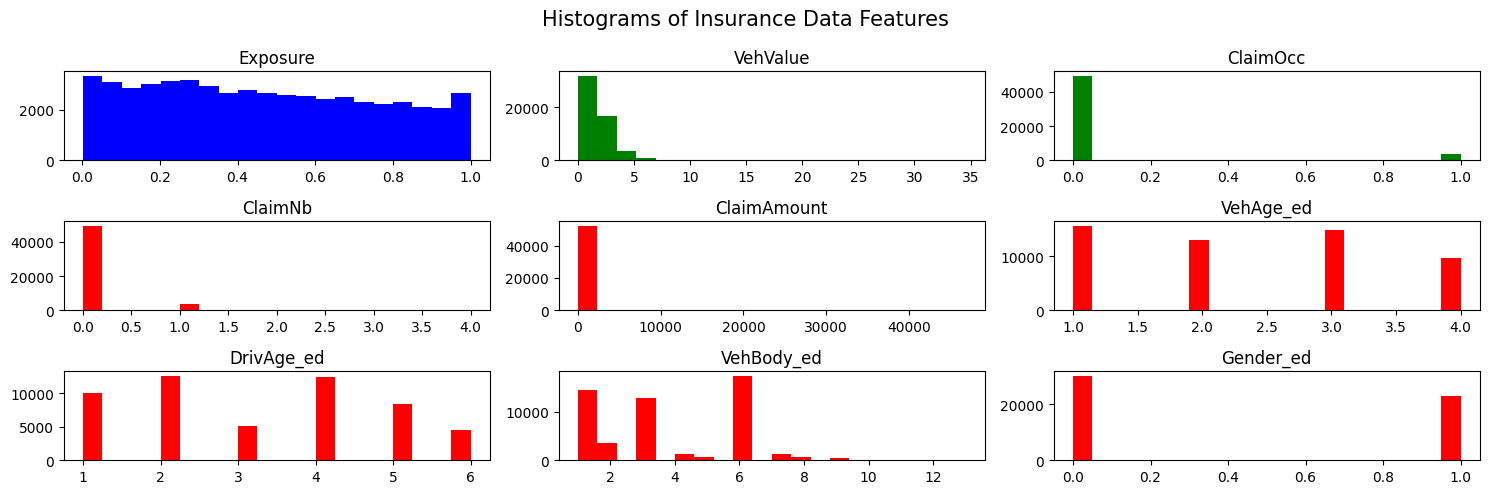

In [ ]:
# Plot histograms of the original features for visualization
plt.rcParams['figure.figsize'] = [15, 5]

fig, ax = subplots(nrows=3,ncols=3)

ax[0,0].hist(X_train['Exposure'], bins=20, color='blue')
ax[0,0].set_title('Exposure')

ax[0,1].hist(X_train['VehValue'], bins=20, color='green')
ax[0,1].set_title('VehValue')

ax[0,2].hist(X_train['ClaimOcc'], bins=20, color='green')
ax[0,2].set_title('ClaimOcc')

ax[1,0].hist(X_train['ClaimNb'], bins=20, color='red')
ax[1,0].set_title('ClaimNb')

ax[1,1].hist(X_train['ClaimAmount'], bins=20, color='red')
ax[1,1].set_title('ClaimAmount')

ax[1,2].hist(X_train['VehAge'], bins=20, color='red')
ax[1,2].set_title('VehAge_ed')

ax[2,0].hist(X_train['DrivAge'], bins=20, color='red')
ax[2,0].set_title('DrivAge_ed')

ax[2,1].hist(X_train['VehBody'], bins=20, color='red')
ax[2,1].set_title('VehBody_ed')

ax[2,2].hist(X_train['Gender'], bins=20, color='red')
ax[2,2].set_title('Gender_ed')


plt.suptitle('Histograms of Insurance Data Features', fontsize=15)
plt.tight_layout()
plt.show()

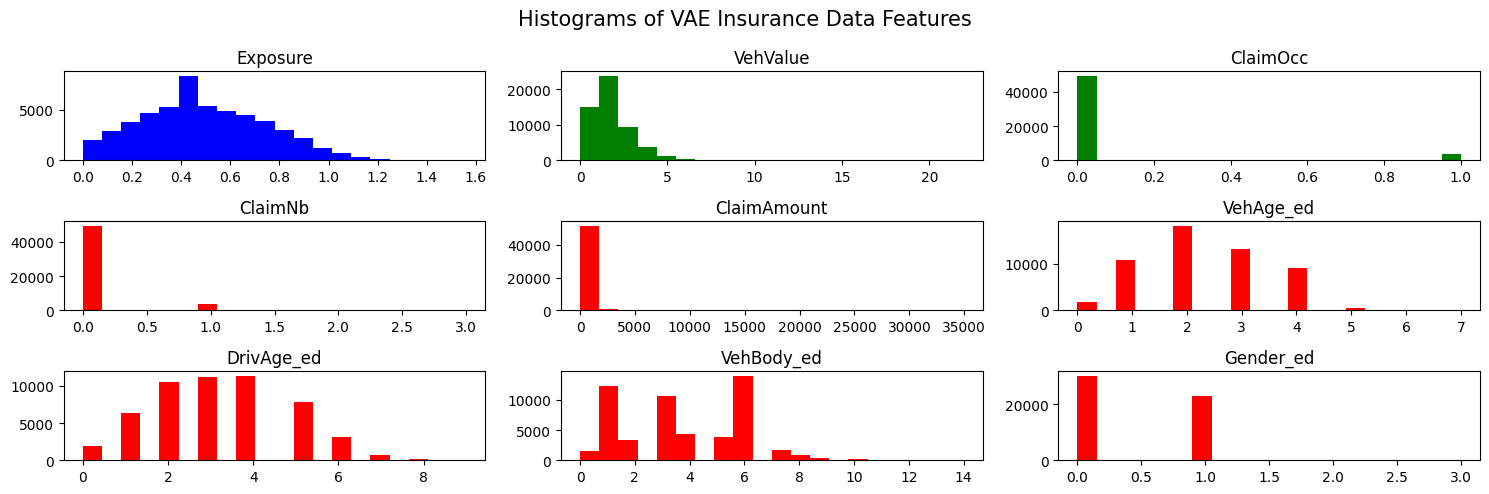

In [ ]:
# Plot histograms of the original features for visualization
plt.rcParams['figure.figsize'] = [15, 5]

fig, ax = subplots(nrows=3,ncols=3)

ax[0,0].hist(new_samples_df['Exposure'], bins=20, color='blue')
ax[0,0].set_title('Exposure')

ax[0,1].hist(new_samples_df['VehValue'], bins=20, color='green')
ax[0,1].set_title('VehValue')

ax[0,2].hist(new_samples_df['ClaimOcc'], bins=20, color='green')
ax[0,2].set_title('ClaimOcc')

ax[1,0].hist(new_samples_df['ClaimNb'], bins=20, color='red')
ax[1,0].set_title('ClaimNb')

ax[1,1].hist(new_samples_df['ClaimAmount'], bins=20, color='red')
ax[1,1].set_title('ClaimAmount')

ax[1,2].hist(new_samples_df['VehAge'], bins=20, color='red')
ax[1,2].set_title('VehAge_ed')

ax[2,0].hist(new_samples_df['DrivAge'], bins=20, color='red')
ax[2,0].set_title('DrivAge_ed')

ax[2,1].hist(new_samples_df['VehBody'], bins=20, color='red')
ax[2,1].set_title('VehBody_ed')

ax[2,2].hist(new_samples_df['Gender'], bins=20, color='red')
ax[2,2].set_title('Gender_ed')


plt.suptitle('Histograms of VAE Insurance Data Features', fontsize=15)
plt.tight_layout()
plt.show()

### Statistical Analysis

In [ ]:
# Kolmogorov-Smirnov test
for column in X_train.columns:
    original = X_train[column].values
    generated = new_samples_df[column].values
    statistic, p_value = ks_2samp(original, generated)
    print(f"KS Test for {column}: Statistic={statistic}, P-value={p_value}")

KS Test for Exposure: Statistic=0.11250937734433608, P-value=2.0714326903600045e-294
KS Test for VehValue: Statistic=0.04684921230307577, P-value=2.740743614755706e-51
KS Test for VehAge: Statistic=0.06142160540135033, P-value=7.075088919109858e-88
KS Test for VehBody: Statistic=0.062378094523630856, P-value=1.2669250026076326e-90
KS Test for Gender: Statistic=0.0010690172543136311, P-value=0.9999999999999999
KS Test for DrivAge: Statistic=0.07274943735933986, P-value=3.8075730852839426e-123
KS Test for ClaimOcc: Statistic=0.0, P-value=1.0
KS Test for ClaimNb: Statistic=0.00011252813203299628, P-value=1.0
KS Test for ClaimAmount: Statistic=0.014947486871717874, P-value=1.3263989226832139e-05


### PCA Analysis

In [ ]:
scaler = StandardScaler()

In [ ]:
X_train_sc = scaler.fit_transform(X_train)
pca_train = PCA(n_components=3).fit_transform(X_train_sc)


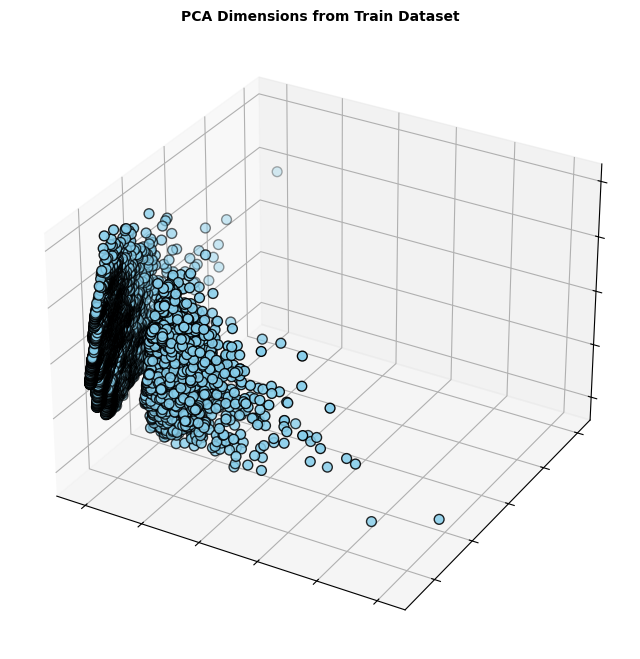

In [ ]:
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')
# Scatter plot using the first three principal components
scatter = ax.scatter(
    pca_train[:, 0],  # 1st principal component
    pca_train[:, 1],  # 2nd principal component
    pca_train[:, 2],  # 3rd principal component
    c='skyblue',       # Color of the points
    edgecolor='k',     # Edge color for points
    s=50               # Size of the points
)

# Set the title and labels
ax.set_title("PCA Dimensions from Train Dataset", fontsize=10, weight='bold')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])


# Show the plot
plt.show()

In [ ]:
new_samples_sc = scaler.fit_transform(new_samples_df)
pca_new_samples = PCA(n_components=3).fit_transform(new_samples_sc)


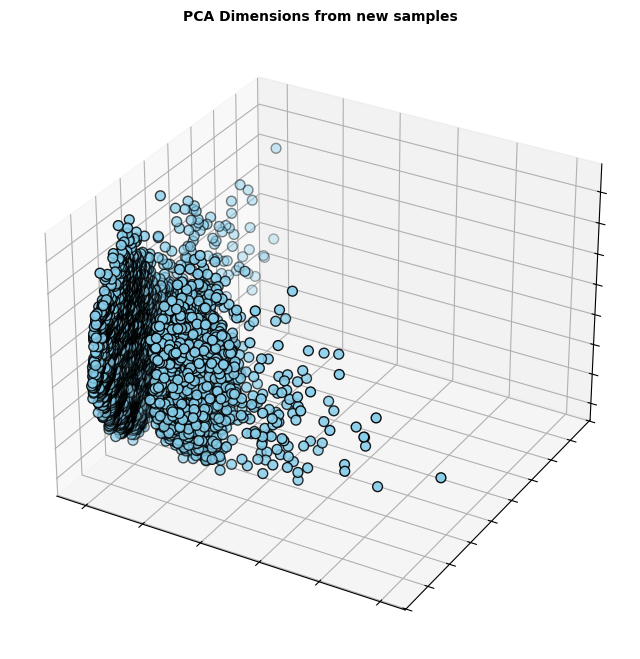

In [ ]:
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')
# Scatter plot using the first three principal components
scatter = ax.scatter(
    pca_new_samples[:, 0],  # 1st principal component
    pca_new_samples[:, 1],  # 2nd principal component
    pca_new_samples[:, 2],  # 3rd principal component
    c='skyblue',       # Color of the points
    edgecolor='k',     # Edge color for points
    s=50               # Size of the points
)

# Set the title and labels
ax.set_title("PCA Dimensions from new samples", fontsize=10, weight='bold')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])


# Show the plot
plt.show()

### UMAP Analysis

In [ ]:
umap_train = umap.UMAP(n_components=3).fit_transform(X_train_sc)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


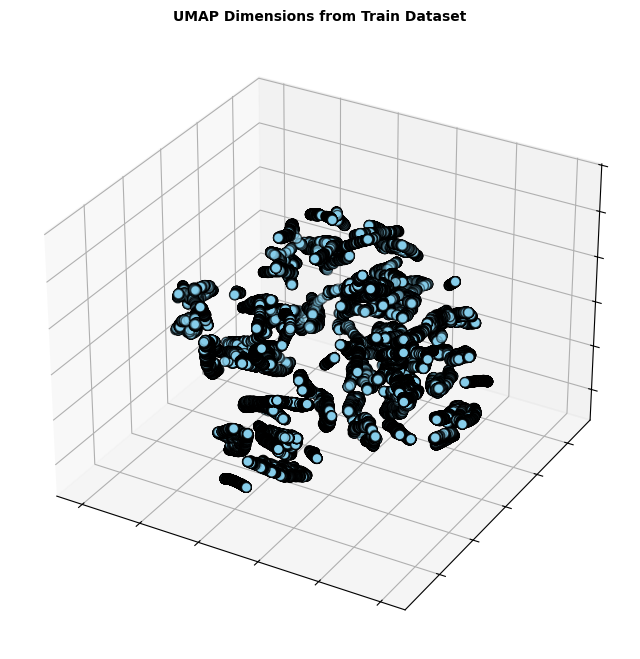

In [ ]:
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')
# Scatter plot using the first three principal components
scatter = ax.scatter(
    umap_train[:, 0],  # 1st principal component
    umap_train[:, 1],  # 2nd principal component
    umap_train[:, 2],  # 3rd principal component
    c='skyblue',       # Color of the points
    edgecolor='k',     # Edge color for points
    s=50               # Size of the points
)

# Set the title and labels
ax.set_title("UMAP Dimensions from Train Dataset", fontsize=10, weight='bold')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])


# Show the plot
plt.show()

In [ ]:
umap_new_samples = umap.UMAP(n_components=3).fit_transform(new_samples_sc)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


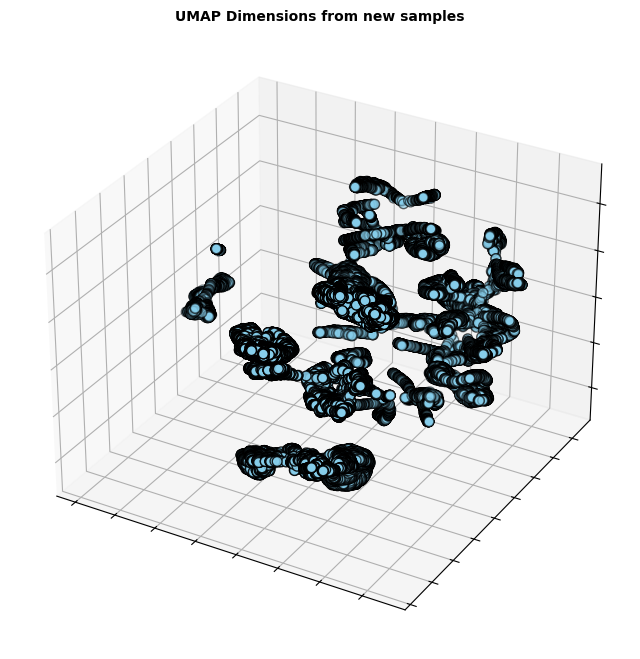

In [ ]:
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')
# Scatter plot using the first three principal components
scatter = ax.scatter(
    umap_new_samples[:, 0],  # 1st principal component
    umap_new_samples[:, 1],  # 2nd principal component
    umap_new_samples[:, 2],  # 3rd principal component
    c='skyblue',       # Color of the points
    edgecolor='k',     # Edge color for points
    s=50               # Size of the points
)

# Set the title and labels
ax.set_title("UMAP Dimensions from new samples", fontsize=10, weight='bold')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])


# Show the plot
plt.show()

### GLM Frequency Analysis

In [ ]:
X_train_freq=X_train.copy()
X_test_freq=X_test.copy()

exposure_tr_freq=X_train_freq['Exposure']
y_train_nb=X_train_freq['ClaimNb']
exposure_te_freq=X_test_freq['Exposure']
y_test_nb=X_test_freq['ClaimNb']
X_train_freq_=X_train_freq.drop(['Exposure','ClaimAmount','ClaimNb'], axis=1)
X_test_freq_=X_test_freq.drop(['Exposure','ClaimAmount','ClaimNb'], axis=1)


In [ ]:
np.random.seed(0)
glm_nb=TweedieRegressor(power=1, link='log')
glm_nb.fit(X_train_freq_, y_train_nb/exposure_tr_freq, sample_weight=exposure_tr_freq)

TweedieRegressor(link='log', power=1)

In [ ]:
glm_nb_pred_tr = glm_nb.predict(X_train_freq_)
glm_nb_pred_te = glm_nb.predict(X_test_freq_)

In [ ]:
mpd_train_1 = mean_poisson_deviance(y_train_nb/exposure_tr_freq, glm_nb_pred_tr)
mpd_test_1 = mean_poisson_deviance(y_test_nb/exposure_te_freq, glm_nb_pred_te)

In [ ]:
mpd_train_1

1.4344568519034897

In [ ]:
mpd_test_1

1.741190103494106

In [ ]:
X_train_sample_freq=new_samples_df.copy()
X_test_sample_freq=X_test.copy()

exposure_sample_tr_freq=X_train_sample_freq['Exposure']
y_train_sample_nb=X_train_sample_freq['ClaimNb']
exposure_sample_te_freq=X_test_sample_freq['Exposure']
y_test_sample_nb=X_test_sample_freq['ClaimNb']
X_train_sample_freq_=X_train_sample_freq.drop(['Exposure','ClaimAmount','ClaimNb'], axis=1)
X_test_sample_freq_=X_test_sample_freq.drop(['Exposure','ClaimAmount','ClaimNb'], axis=1)


In [ ]:
np.random.seed(0)
glm_sample_nb=TweedieRegressor(power=1, link='log')
glm_sample_nb.fit(X_train_sample_freq_, y_train_sample_nb/exposure_sample_tr_freq, sample_weight=exposure_sample_tr_freq)

TweedieRegressor(link='log', power=1)

In [ ]:
glm_sample_nb_pred_tr = glm_sample_nb.predict(X_train_sample_freq_)
glm_sample_nb_pred_te = glm_sample_nb.predict(X_test_sample_freq_)

In [ ]:
mpd_train_2 = mean_poisson_deviance(y_train_sample_nb/exposure_sample_tr_freq, glm_sample_nb_pred_tr)
mpd_test_2 = mean_poisson_deviance(y_test_sample_nb/exposure_sample_te_freq, glm_sample_nb_pred_te)

In [ ]:
mpd_train_2

1.1329799641383096

In [ ]:
mpd_test_2

1.755724045321314

### GLM Cost Analysis

In [ ]:
X_train_co=X_train.copy()
X_test_co=X_test.copy()

X_train_co['Acost'] = np.where(X_train_co['ClaimNb'] != 0, X_train_co['ClaimAmount'] / X_train_co['ClaimNb'], 0)
X_test_co['Acost'] = np.where(X_test_co['ClaimNb'] != 0, X_test_co['ClaimAmount'] / X_test_co['ClaimNb'], 0)

L1 = X_train_co["ClaimAmount"] != 0
X_train_cost = X_train_co[L1]
L2 = X_test_co["ClaimAmount"] != 0
X_test_cost = X_test_co[L2]

exposure_tr_cost=X_train_cost['Exposure']
claim_tr=X_train_cost['ClaimNb']
y_train_cl=X_train_cost['Acost']
exposure_te_cost=X_test_cost['Exposure']
claim_te=X_test_cost['ClaimNb']
y_test_cl=X_test_cost['Acost']
X_train_cost_=X_train_cost.drop(['Acost','Exposure','ClaimAmount','ClaimNb'], axis=1)
X_test_cost_=X_test_cost.drop(['Acost','Exposure','ClaimAmount','ClaimNb'], axis=1)


In [ ]:
np.random.seed(0)
glm_cl=TweedieRegressor(power=2, link='log')
glm_cl.fit(X_train_cost_, y_train_cl, sample_weight=claim_tr)

TweedieRegressor(link='log', power=2)

In [ ]:
glm_cl_pred_tr = glm_cl.predict(X_train_cost_)
glm_cl_pred_te = glm_cl.predict(X_test_cost_)

In [ ]:
mgd_train_1 = mean_gamma_deviance(y_train_cl, glm_cl_pred_tr)
mgd_test_1 = mean_gamma_deviance(y_test_cl, glm_cl_pred_te)

In [ ]:
mgd_train_1

1.5508741472884895

In [ ]:
mgd_test_1

1.7221300040077396

In [ ]:
X_sample_train_co=new_samples_df.copy()
X_sample_test_co=X_test.copy()

X_sample_train_co['Acost'] = np.where(X_sample_train_co['ClaimNb'] != 0, X_sample_train_co['ClaimAmount'] / X_sample_train_co['ClaimNb'], 0)
X_sample_test_co['Acost'] = np.where(X_sample_test_co['ClaimNb'] != 0, X_sample_test_co['ClaimAmount'] / X_sample_test_co['ClaimNb'], 0)

L1 = X_sample_train_co["ClaimAmount"] != 0
X_sample_train_cost = X_sample_train_co[L1]
L2 = X_sample_test_co["ClaimAmount"] != 0
X_sample_test_cost = X_sample_test_co[L2]

exposure_tr_sample_cost=X_sample_train_cost['Exposure']
claim_sample_tr=X_sample_train_cost['ClaimNb']
y_sample_train_cl=X_sample_train_cost['Acost']
exposure_te_sample_cost=X_sample_test_cost['Exposure']
claim_sample_te=X_sample_test_cost['ClaimNb']
y_sample_test_cl=X_sample_test_cost['Acost']
X_sample_train_cost_=X_sample_train_cost.drop(['Acost','Exposure','ClaimAmount','ClaimNb'], axis=1)
X_sample_test_cost_=X_sample_test_cost.drop(['Acost','Exposure','ClaimAmount','ClaimNb'], axis=1)


In [ ]:
np.random.seed(0)
glm_sample_cl=TweedieRegressor(power=2, link='log')
glm_sample_cl.fit(X_sample_train_cost_, y_sample_train_cl, sample_weight=claim_sample_tr)

TweedieRegressor(link='log', power=2)

In [ ]:
glm_sample_cl_pred_tr = glm_sample_cl.predict(X_sample_train_cost_)
glm_sample_cl_pred_te = glm_sample_cl.predict(X_sample_test_cost_)

In [ ]:
mgd_sample_train_1 = mean_gamma_deviance(y_sample_train_cl, glm_sample_cl_pred_tr)
mgd_sample_test_1 = mean_gamma_deviance(y_sample_test_cl, glm_sample_cl_pred_te)

In [ ]:
mgd_sample_train_1

1.3539236483152581

In [ ]:
mgd_sample_test_1

1.7148949128677986

### Feature Importance Analysis

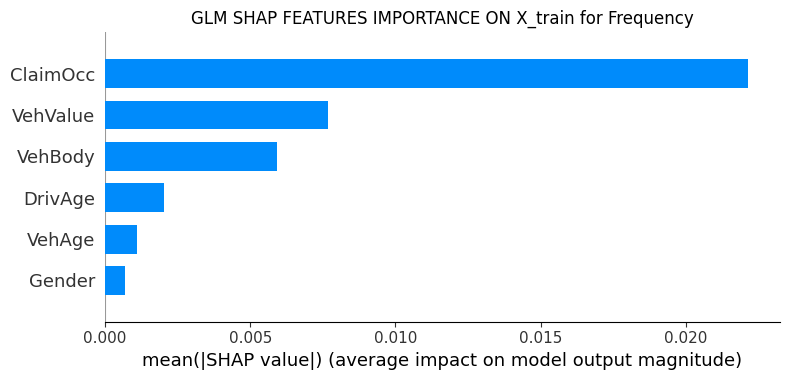

In [ ]:
# Global SHAP on GLM
np.random.seed(0)
GLM_freq = TweedieRegressor(power=1,link='log').fit(X_train_freq_, y_train_nb/exposure_tr_freq, sample_weight=exposure_tr_freq)
masker = shap.maskers.Independent(X_train_freq_)
GLM_explainer = shap.LinearExplainer(GLM_freq, masker=masker)
GLM_shap_values = GLM_explainer.shap_values(X_test_freq_)
plt.rcParams['figure.figsize'] = (5,5)
plt.title("GLM SHAP FEATURES IMPORTANCE ON X_train for Frequency")
shap.summary_plot(GLM_shap_values, features=X_test_freq_, feature_names=X_test_freq_.columns,plot_type='bar',max_display=10)

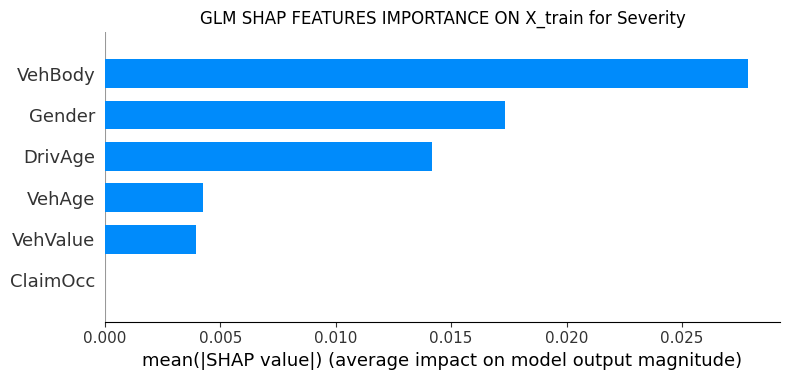

In [ ]:
# Global SHAP on GLM
np.random.seed(0)
GLM_cost = TweedieRegressor(power=2,link='log').fit(X_train_cost_, y_train_cl, sample_weight=claim_tr)
masker = shap.maskers.Independent(X_train_cost_)
GLM_explainer = shap.LinearExplainer(GLM_cost, masker=masker)
GLM_shap_values = GLM_explainer.shap_values(X_test_cost_)
plt.rcParams['figure.figsize'] = (5,5)
plt.title("GLM SHAP FEATURES IMPORTANCE ON X_train for Severity")
shap.summary_plot(GLM_shap_values, features=X_test_cost_, feature_names=X_test_cost_.columns,plot_type='bar',max_display=10)

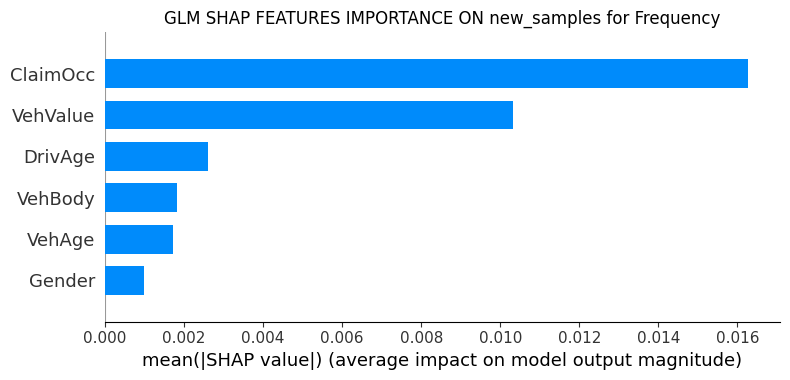

In [ ]:
# Global SHAP on GLM
np.random.seed(0)
GLM_sample_freq = TweedieRegressor(power=1,link='log').fit(X_train_sample_freq_, y_train_sample_nb/exposure_sample_tr_freq, sample_weight=exposure_sample_tr_freq)
masker = shap.maskers.Independent(X_train_sample_freq_)
GLM_explainer = shap.LinearExplainer(GLM_sample_freq, masker=masker)
GLM_shap_values = GLM_explainer.shap_values(X_test_sample_freq_)
plt.rcParams['figure.figsize'] = (5,5)
plt.title("GLM SHAP FEATURES IMPORTANCE ON new_samples for Frequency")
shap.summary_plot(GLM_shap_values, features=X_test_sample_freq_, feature_names=X_test_sample_freq_.columns,plot_type='bar',max_display=10)

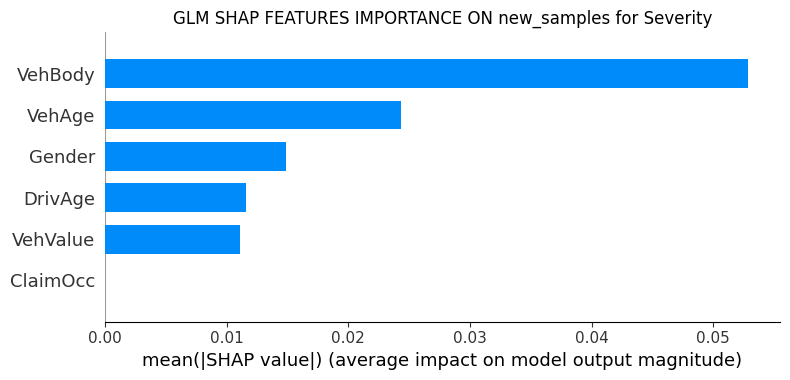

In [ ]:
# Global SHAP on GLM
np.random.seed(0)
GLM_sample_cost = TweedieRegressor(power=2,link='log').fit(X_sample_train_cost_, y_sample_train_cl, sample_weight=claim_sample_tr)
masker = shap.maskers.Independent(X_sample_train_cost_)
GLM_explainer = shap.LinearExplainer(GLM_sample_cost, masker=masker)
GLM_shap_values = GLM_explainer.shap_values(X_sample_test_cost_)
plt.rcParams['figure.figsize'] = (5,5)
plt.title("GLM SHAP FEATURES IMPORTANCE ON new_samples for Severity")
shap.summary_plot(GLM_shap_values, features=X_sample_test_cost_, feature_names=X_sample_test_cost_.columns,plot_type='bar',max_display=10)